## Setup
Depending your initial notebook type e.g. (conda_python3, tensorflow, pure python, etc..)
You might face errors for missing packages, here, we are running an inline import with pip, you can add the missing packages as well

In [ ]:
!pip install nltk tweepy tabulate textblob langdetect language_check wordcloud

In [ ]:
import re 
import sys
import nltk
import tweepy 
import numpy as np
from tabulate import tabulate
from textblob import TextBlob
from langdetect import detect
from tweepy import OAuthHandler 
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.parse.generate import generate, demo_grammar
from nltk.parse import ShiftReduceParser
from nltk import CFG
import language_check
from textblob.decorators import requires_nltk_corpus
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from __future__ import print_function

In [21]:
class TwitterAnalyzer(object): 
	_classifier = None

	_checkLang = ''

	# The ignored words are twitter hashtags, links, smileys, and the search word themselves
	# This set is not final, stopwords from the wordCloud , NLTK are included also
	ignored_words = {'RT', '#', 'https', '_twt'}

	# the detected langs are sets of unique elements
	detected_langs = set()

	# words dictionary
	words = []
	search_words = []

	stop_words = []


	def __init__(self):
		self._checkLang =  language_check.LanguageTool('en-US')

		print(f'\nDownloading/fetching stopwords and pucktuations ..')
		nltk.download('stopwords')
		nltk.download('punkt')
		print(f'Crunching data ..\n')

		# TODO insert your Twitter API keys here
		# Create a developer account and request access
		# @link{ https://developer.twitter.com/en/apply-for-access.html} 
		consumer_key        = '<your key goes here>'
		consumer_secret     = '<your key goes here>'
		access_token        = '<your key goes here>'
		access_token_secret = '<your key goes here>'

		try: 
			self.auth = OAuthHandler(consumer_key, consumer_secret) 
			self.auth.set_access_token(access_token, access_token_secret) 
			self.api = tweepy.API(self.auth)  
			# print(self.api.auth._get_request_token.value)

		except: 
			print("Error: Authentication Failed") 

		
	
	def sanitize_text(self, text):
		try:
			if detect(text) == 'en':
				allow_in_dict = True
			else:
				allow_in_dict = False
		except:
			allow_in_dict = False

		# remove non-words
		sanitized_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) 

		self.stop_words = set(stopwords.words('english'))
		self.stop_words.update(STOPWORDS)
		self.stop_words.update(self.ignored_words)
		
		word_tokens = word_tokenize(sanitized_text) 
  
		#filtered_sentence = [w for w in word_tokens if not w in stop_words and len(w) > 1] 
  
		filtered_sentence = [] 
		# not ignored and > 1 (punctation and stuff)
		for w in word_tokens: 
		    if w not in self.stop_words and len(w) > 3 and allow_in_dict : 
		        filtered_sentence.append(w) 
		#print (filtered_sentence)

		# add words without stopwords to list
		self.words += filtered_sentence

		# I am going to need the whole text for a better classification
		return sanitized_text


	def train(self):
		super(NaiveBayesAnalyzer, self).train()
		self._classifier = nltk.classify.NaiveBayesClassifier.train(train_data)
		

	# Classify by polarity and subjectivity using TextBlob
	def get_sentiment(self, text):
		# Keep idomatic text
		text = self.sanitize_text(text)

		analysis = TextBlob(text)

		# set sentiment 
		if analysis.sentiment.polarity > 0:  
			return 'positive'
		elif analysis.sentiment.polarity == 0: 
			return 'neutral'
		else: 
			return 'negative'


	def guess_the_news(self, words):
		temp = set()
		for word in words:
			temp.add(word[0])
	
		matches = self._checkLang.check(' '.join(temp))
		
		print (f'\nHere is an auto-generated guess of what people are saying:\n')

		print (language_check.correct(' '.join(temp), matches))
		

	def fetch_tweets(self, query, count = 500): 
		# empty list to store parsed tweets 
		tweets = [] 

		# the words included in the query should be ignored from most frequently used words
		self.ignored_words.update(query.split())
		#print (self.ignored_words)
	
		try: 
			# fetch tweets 
			fetched_tweets = self.api.search(q = query, count=count) 
			# extract tweet body and guess sentiment 
			for tweet in fetched_tweets: 
				# empty dictionary for tweet, sentiment 
				parsed_tweet = {} 
				parsed_tweet['text'] = tweet.text.lower()
				parsed_tweet['sentiment'] = self.get_sentiment(tweet.text) 

				# Exclude retweets
				if tweet.retweet_count > 0: 
					if parsed_tweet not in tweets: 
						tweets.append(parsed_tweet) 
				else: 
					tweets.append(parsed_tweet) 

			# Parsed tweets 
			return tweets 

		except tweepy.TweepError as e: 
			print("Error : " + str(e)) 



## Main method for initializing and displaying output

In [ ]:
def main(): 
	# creating object of TwitterClient Class 
	api = TwitterAnalyzer() 
	# calling function to get tweets 
	tweets = api.fetch_tweets(query = sys.argv[1], count = sys.argv[2] if len(sys.argv) < 2 else 500)

	# most occuring real wordsgue
	terms_occurence = Counter(api.words)
	print(f'\nMost frequently used words')
	print(terms_occurence.most_common(5))


	# picking positive tweets from tweets 
	ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
	ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']  

	positive_tweet_percentage = 100 * len(ptweets)/len(tweets)
	negative_tweet_percentage = 100 * len(ntweets)/len(tweets)
	natural_tweet_percentage  = 100 * ( len(tweets) - len(ntweets) - len(ptweets) ) / len(tweets)

	table = [["Positive",len(ptweets),positive_tweet_percentage],
	["Negative",len(ntweets),negative_tweet_percentage],
	["Neutral",( len(tweets) - len(ntweets) - len(ptweets)),natural_tweet_percentage],
	["Total", len(tweets), 100 * len(tweets)/len(tweets) ]]

	# print a grid-formatted table with stats.
	print (f'\nProcessed tweets stats (non english and REs ignored).\n')
	print(tabulate(table, headers=["Polarity","Number", "Percentage"],tablefmt="grid"))

	
	dictionary_str = ' '.join(api.words)

	api.guess_the_news(terms_occurence.most_common(15))


	# Config and show cloud of most used words
	wordcloud = WordCloud(stopwords=api.stop_words, max_font_size=40).generate(dictionary_str)
	plt.figure()
	plt.imshow(wordcloud, interpolation="bilinear")
	plt.axis("off")
	plt.show()

## Example run


Downloading/fetching stopwords and pucktuations ..
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Crunching data ..


Most frequently used words
[('deal', 12), ('vote', 8), ('people', 7), ('party', 6), ('must', 6)]

Processed tweets stats (non english and REs ignored).

+------------+----------+--------------+
| Polarity   |   Number |   Percentage |
+============+==========+==============+
| Positive   |       23 |      28.3951 |
+------------+----------+--------------+
| Negative   |       20 |      24.6914 |
+------------+----------+--------------+
| Neutral    |       38 |      46.9136 |
+------------+----------+--------------+
| Total      |       81 |     100      |
+------------+----------+--------------+

Here is an auto-generated guess of what people are saying:


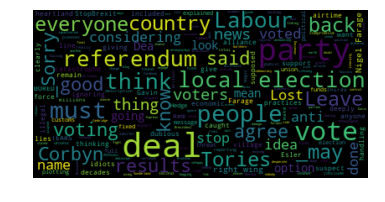

In [22]:
main('Brexit')